# Programmatic Spherical Entropy and Information Calculations -- Demo Notebook

## 0. Setup

### 0.1. Imports

In [1]:
## Set the PYTHON package path
import os, sys
package_root = os.path.abspath('../src/')
if package_root not in sys.path:
    sys.path.insert(0, package_root)

#package_root

In [2]:
## Import all soft entropy calculation routines
#from nam_entropy import *

## --------------------------------------------

## Import randomness utilities
from nam_entropy.utils import set_all_random_seeds

## Import our data creation / prep routines
from nam_entropy.make_data import make_samples_dataframe_from_distributions
from nam_entropy.data_prep import data_df_to_pytorch_data_tensors_and_labels

## Import soft entropy calculation routines
from nam_entropy.h import soft_bin, entropy 

## Import visualization routines
from nam_entropy.bin_distribution_plots import plot_tensor_bars, \
                                               plot_unit_circle_scatter, \
                                               plot_unit_circle_scatter_labeled, \
                                               compute_non_overlapping_ray_radii


In [3]:
# Import SciPy distributions
from scipy import stats

## Import the Pytorch distributions
import torch

## Import 
import matplotlib.pyplot as plt
import numpy as np

### 0.2. Fix Randomness

In [4]:
RANDOM_SEED = 42
set_all_random_seeds(RANDOM_SEED)

All random seeds set to 42 (deterministic mode)


## 1. Create Sample Data

In [5]:
## Define some example SciPy distributions in 2D
dist1 = stats.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]]) # Standard normal
dist2 = stats.multivariate_normal(mean=[1.5, 3], cov=[[1, 0.5], [0.5, 1]]) # Different normal with correlations

## Define some example PyTorch distributions in 2D
from torch.distributions import Uniform
dist3 = Uniform(
    low=torch.tensor([-2.0, -1.0]),
    high=torch.tensor([2.0, 0.0])
)


In [6]:
## Get some associated sample data from these distributions
n_samples_list = [10, 20, 30]
distribution_list = [dist1, dist2, dist3]
label_list = ['A - Std Normal', 'B - Correlated Normal', 'C - Uniform on [-2, 2] x [-1, 0]']

randomized_data_df = \
    make_samples_dataframe_from_distributions(n_samples_list, distribution_list, label_list, 
                                              label_columns_name = 'label', 
                                              data_component_name_list=None, 
                                              randomize_samples = True)


## 2. Pytorch Preparation of Sample Data

In [7]:
## Convert the data to PyTorch format
index_tensor, data_tensor, label_list, label_list_row_index_lookup_dict = \
    data_df_to_pytorch_data_tensors_and_labels(randomized_data_df)

## 3. Create Soft-binned Probability Distributions

### 3.1. Create the soft-binned probability distributions for each point

In [8]:
## Setup the soft-binning for the unit sphere with softmax smoothing
n_bins = 10
n_heads = 1
bin_type = "unit_sphere"
dist_fn = "cosine"
smoothing_fn = "softmax"
smoothing_temp = 1.0

## Previous non-sphere settings should have been this!
#bin_type = "uniform"
#dist_fn = "euclidean"
#smoothing_fn = "None"
#smoothing_temp = 1.0  ## IRRELEVANT


## Perform the soft-binning
tmp_scores, tmp_bins = \
    soft_bin(all_representations = data_tensor, \
             n_bins = n_bins, n_heads = n_heads, \
             smoothing_fn = smoothing_fn, smoothing_temp = smoothing_temp)


## Get the data tensor with no extra n_heads variable -- from [N, n_heads = 1, n_bins] --> [N, n_bins]
tmp_scores = tmp_scores.squeeze(1)
tmp_bins = tmp_bins.squeeze(1)

## Show the shape of the final probability distribution tensor -- should be [N, n_bins]
tmp_scores.shape                                                                  

torch.Size([60, 10])

### 3.1.1. Explore Bins and the underlying data

In [9]:
## Look at the given soft-bin points
tmp_bins

tensor([[-0.7847, -0.4779],
        [-0.3538,  1.9947],
        [ 1.0809,  3.4868],
        [-1.8134,  0.0537],
        [ 0.2337,  4.0293],
        [-1.3536,  0.8071],
        [-0.5043,  4.3289],
        [ 2.3500,  0.5309],
        [-1.4713,  2.3015],
        [ 0.9998,  2.5984]], dtype=torch.float64)

(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Unit Circle Scatter Plot'}, xlabel='x', ylabel='y'>)

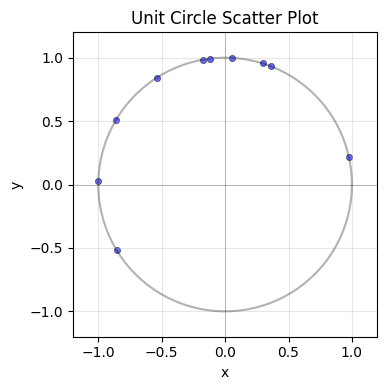

In [10]:
## Plot the soft-bin points on the unit circle
plot_unit_circle_scatter(tmp_bins, figsize=(4,4))

### 3.1.2. Create the labelled data plot

In [11]:
# Looser spacing
ray_radii = compute_non_overlapping_ray_radii(
  tmp_bins,
  ray_indices=[2, 3, 4, 6, 7, 9, 10],
  base_radius=1.5,
  min_angular_separation=10.0,  # Smaller threshold
  radius_increment=0.25          # Smaller jumps
)

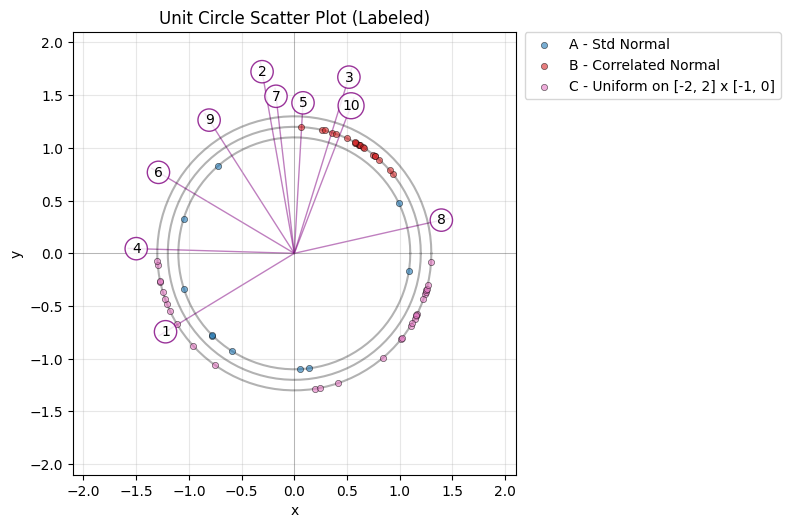

In [12]:
# Now plot with the computed radii
fig, ax = plot_unit_circle_scatter_labeled(
  data_tensor,
  index_tensor=index_tensor,
  label_list=label_list,
  label_radii={label_list[0]: 1.1, label_list[1]: 1.2, label_list[2]: 1.3},
  ray_directions=tmp_bins,
#  ray_indices=[2, 3, 4, 6, 7, 9, 10],
  ray_indices=list(range(1, 10+1)),
  ray_label_radius=ray_radii,  # Use computed radii
  ray_color='purple'
)

### 3.2. Create the probability distribution for the total population (all labels together)

In [13]:
## Compute the sum of all soft-binned probability distibutions
prob_dist_sum_tensor = tmp_scores.sum(0)

In [14]:
## Compute the total population probability vector
prob_dist_for_total_population_tensor = prob_dist_sum_tensor / tmp_scores.shape[0]

In [15]:
## Check its values
prob_dist_for_total_population_tensor

tensor([0.2221, 0.0764, 0.1100, 0.1067, 0.0548, 0.0972, 0.0281, 0.1509, 0.0367,
        0.1170], dtype=torch.float64)

In [16]:
## Check that it's a probability distribution
prob_dist_for_total_population_tensor.sum().item() == 1.0

True

### 3.3. Create the probability distributions for each population label

In [17]:
## Prepare to compute the index sum
num_samples = index_tensor.shape[0]  ## also data_tensor.shape[0]
n_bins = tmp_scores.shape[-1]  ## prob_dist_num_of_points
num_labels = len(label_list)

## Get the data tensor with no extra n_heads variable
tmp_scores__no_heads = tmp_scores.squeeze(1)

## Compute the sum of the soft-binned probability distributions for each label
label_prob_dist_sum_tensor = torch.zeros(num_labels, n_bins, dtype = tmp_scores__no_heads.dtype)
label_prob_dist_sum_tensor = label_prob_dist_sum_tensor.index_add(dim=0, source=tmp_scores__no_heads, index=index_tensor)


label_prob_dist_sum_tensor.shape


torch.Size([3, 10])

In [18]:
## Check the sum over the columns agree with the number of samples per label -- yes! =)
#label_prob_dist_sum_tensor.sum(1)

In [19]:
## Determine the label counts (i.e. the number of samples for each label)
label_counts_tensor = torch.bincount(index_tensor)

## Divide by the label counts to get the probability distributions of each label as a row
label_prob_dist_avg_tensor = label_prob_dist_sum_tensor / label_counts_tensor.unsqueeze(1)

## Define the probability distributions for each label
prob_dist_by_label_tensor = label_prob_dist_avg_tensor

In [20]:
## Check that the average again is a probability distribution
#prob_dist_by_label_tensor.sum(1)

### 3.4. Determine the probability distribution of labels -- for later use in conditional entropy calculation

In [21]:
## Compute the probabilities of the labels
distribution_of_labels = (index_tensor.bincount() / index_tensor.shape[0]).to(torch.float64)

distribution_of_labels.shape

torch.Size([3])

In [22]:
#distribution_of_labels

### 3.5. Visualize the probability distributions

#### 3.5.1. Check the probability tensors we're given

In [23]:
#prob_dist_for_total_population_tensor

In [24]:
#prob_dist_by_label_tensor

#### 3.5.2. Define the barplot routine to visualize the probability tensor


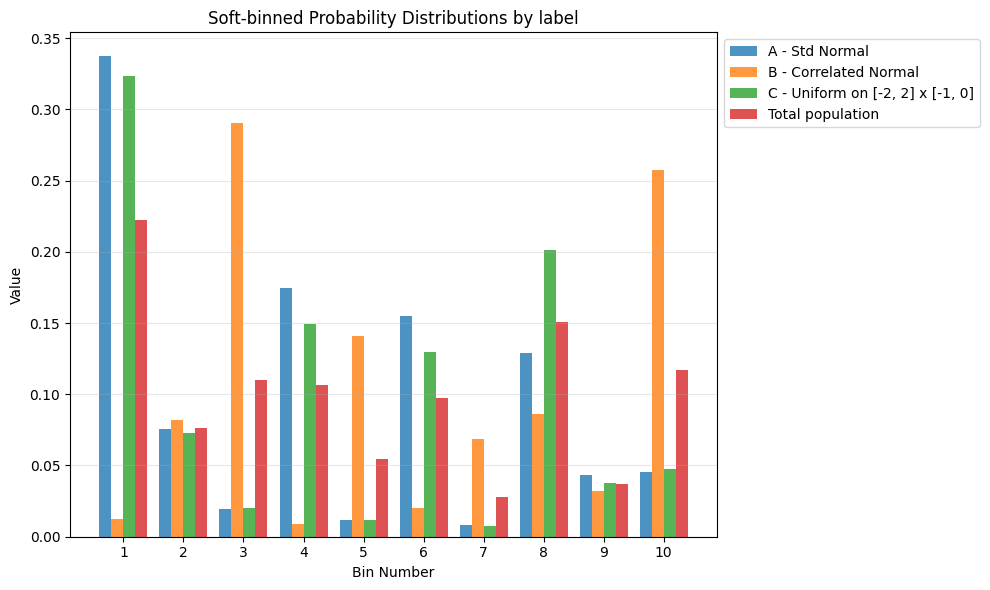

In [25]:
## Make the display tensor and labels
display_label_list = label_list + ['Total population']
display_tensor = torch.cat([prob_dist_by_label_tensor, prob_dist_for_total_population_tensor.unsqueeze(0)], dim=0)

## Plot the soft-binned probability distributions for each of the labels and also for the total population
plot_tensor_bars(display_tensor, title='Soft-binned Probability Distributions by label', 
                 separate_plots=False, labels=display_label_list, xlabel="Bin Number", start_index=1)

## 4. Compute Entropy for each population label

In [26]:
## Compute the entropy for the total population
total_population_entropy = entropy(prob_dist_for_total_population_tensor)
total_population_entropy

tensor(2.1562, dtype=torch.float64)

In [27]:
## Compute the entropy for each label
entropy_by_label_tensor = entropy(prob_dist_by_label_tensor)
entropy_by_label_tensor

tensor([1.8653, 1.8726, 1.8620], dtype=torch.float64)

In [28]:
## Store the entropies in a dictionary for easy reference
entropy_dict = {
    'total_population': total_population_entropy.item()
}
for i, label in enumerate(label_list):
    entropy_dict[label] = entropy_by_label_tensor[i].item()

## Display the dictionary
entropy_dict

{'total_population': 2.156181271337685,
 'A - Std Normal': 1.8653421206154068,
 'B - Correlated Normal': 1.8725551826926834,
 'C - Uniform on [-2, 2] x [-1, 0]': 1.8620171894989874}

## 5. Compute the Conditional Entropy -- for the sample population $Z$ given its label $L$
**Note:** 
We compute the conditional entropies $H(Z|L)$,
where $Z$ is the total population and $L$ is the categorical label variable. 

We use the formula

$H(Z|L) = \sum_{l \in L} p(l) H(Z|L=l)$

where 

$H(Z|L=l) = -\sum_{z \in Z} p(z|l) \log p(z|l)$

Here we define
- $Z$ := Population data distribution (continuous vector-valued RV)
- $L$ := Sub-population label (categorical RV)

[https://en.wikipedia.org/wiki/Conditional_entropy](https://en.wikipedia.org/wiki/Conditional_entropy)

In [29]:
## Let's compute the conditional entropies for the population given the categorical label
conditional_entropy_of_population_given_the_label = torch.dot(distribution_of_labels, entropy_by_label_tensor).item()
conditional_entropy_of_population_given_the_label

1.866084036950375

## 6. Compute Mutual Information between the total population RV and the label RV
By definition, the __mutual information__ ${\displaystyle \operatorname {I} (Z, L)}$ of the two random variables $Z$ and $L$ is given by

${\displaystyle \operatorname {I} (Z, L) := \mathrm {H} (Z) - \mathrm {H} (Z|L)\,}$

and we define 
- $Z$ := Population data distribution (continuous vector-valued RV)
- $L$ := Sub-population label (categorical RV)

In [30]:
## Check: This is non-negative -- as it's supposed to be!
mutual_information = entropy_dict['total_population'] - conditional_entropy_of_population_given_the_label
mutual_information

0.29009723438730983

## 7. Entropy Summmary

In [31]:
entropy_dict['total_population']

2.156181271337685

In [32]:
conditional_entropy_of_population_given_the_label

1.866084036950375

In [33]:
mutual_information

0.29009723438730983

----
## Summary of Objects
1. **Distributions**
    - `dist1`, `dist2`, `dist3`
    - `n_samples_list = [10, 20, 30]`
    - `distribution_list = [dist1, dist2, dist3]`
    - `label_list = ['A - Std Normal', 'B - Correlated Normal', 'C - Uniform on [-2, 2] x [-1, 0]']`      
      
2. **Pytorch Preparation of Sample Data**
    - `index_tensor, data_tensor, label_list, label_list_row_index_lookup_dict`

3. **Soft-Binning**

    3.1. **Create Soft-Bins**
    - `n_bins = 10`
    - `n_heads = 1`
    - `bin_type = "unit_sphere"`
    - `dist_fn = "cosine"`
    - `smoothing_fn = "softmax"`
    - `smoothing_temp = 1.0`
    - `tmp_scores`
    - `tmp_bins`

    3.2. **Create the population probability distributions**
    - `prob_dist_sum_tensor`
    - `prob_dist_for_total_population_tensor`
    - `label_prob_dist_sum_tensor`

4. **Entropy Calculations**
    - `total_population_entropy`
    - `entropy_by_label_tensor`
    - `entropy_dict`
      
5. **Conditional Entropy**
    - `conditional_entropy_of_population_given_the_label`

6. **Mutual Information**
    - `mutual_information`
   